In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.patheffects import withStroke
from matplotlib.colors import to_rgb

import networkx as nx

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

import os
import os.path as op

import importlib

import dgsp
import graph_examples as dgsp_graphs
import plotting as dgsp_plot

import bimod_plots as plot

([], [])

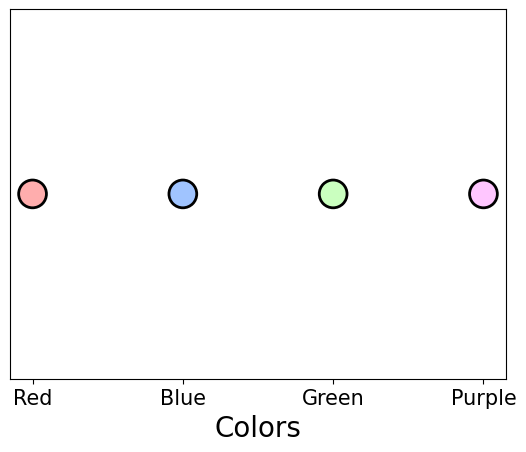

In [3]:
#path_to_figures = "./figures/02-BiMod"
path_to_figures = "/Users/acionca/Library/CloudStorage/GoogleDrive-cionkito@gmail.com/My Drive/01-Work/01-EDEE/papers/201-OHBM2024-BrainBicom"

os.makedirs(path_to_figures, exist_ok=True)

inch_to_cm = 2.54
cm_to_inch = 1/inch_to_cm

# Red, Blue, Green, Purple
colorpalette = ["#FFADAD", "#A0C4FF", "#CAFFBF", "#FFC6FF"]
palette_rgb = [to_rgb(color) for color in colorpalette]
colors_edges = np.array(["tab:red", "tab:blue", "tab:green", "tab:gray"])
markers = ["s", "o", "D", "^"]

# Defining edge alphas and connection styles
edge_a=.2
edge_cs="arc3,rad=0.2"

plt.scatter([0, 1, 2, 3], [0]*4, c=palette_rgb, s=400, edgecolors="k", lw=2)

plt.xlabel("Colors", fontsize=20)
plt.xticks([0, 1, 2, 3], ["Red", "Blue", "Green", "Purple"], fontsize=15)

plt.yticks([])

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap

# x,y = zip(*np.random.rand(1000,2)*4-2)

# norm=plt.Normalize(-2,2)

# color_list = ["#A30029", "#094186", "#7EB67C", "#FF9933", "#F6F6F6"]
# reorder_colors = [4, 0, 3, 1, 2]
# #cmap = LinearSegmentedColormap.from_list("", [to_rgb(color) for i, color in enumerate(color_list)])
# cmap = LinearSegmentedColormap.from_list("", [to_rgb(color_list[reorder_colors[i]]) for i, color in enumerate(color_list)])
# cmap = plt.get_cmap("RdBu_r")

# n_scatter = 3*(len(color_list)-1)+1
# cmap = cmap.resampled(n_scatter)

# #cluster_colors = [cmap.resampled(n_scatter)(i) for i in range(n_scatter)]
# color_ids = [n_scatter//2] + [i//2+1 if i % 2 else i for i in range(n_scatter - 1)]
# cluster_colors = [cmap(i) for i in color_ids]

# #plt.scatter(x,y,c=y, cmap=cmap, norm=norm)
# plt.scatter(np.arange(n_scatter), np.arange(n_scatter), color=cluster_colors, s=100, edgecolors="k", lw=2)
# plt.show()

In [5]:
import sys
path_to_effective = "../../effectivedelay_estimation"
sys.path.append(path_to_effective)

from src import regmod
from src import utils
from src import solver

In [6]:
path_to_data = op.join(path_to_effective, "resources")

# Could be 50, 100, 200, 400
delay_max = 100
#delay_max = 100
scale = 1

#path_to_data = f"/Users/acionca/data/F-TRACT-090624/{delay_max}" #/probability.txt.gz"
#path_to_ftract = f"/Users/acionca/data/F-TRACT-090624/{delay_max}" #/probability.txt.gz"

#filename = "adjacency_atlas.pkl"
filename = f"bundle_probability_atlas-scale{scale}.pkl"

bundle_prob = utils.load(op.join(path_to_data, filename))
bundle_prob = bundle_prob[:-2][:, :-2]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = utils.load(op.join(path_to_data, f"adj_probability_ftract-d{delay_max}-scale{scale}.pkl"))
ftract_prob = ftract_prob[:-2][:, :-2]

print(bundle_prob.shape)
print(ftract_prob.shape)

node_centers = utils.load(f"/Users/acionca/code/effectivedelay_estimation/resources/roi_centers-ftract-scale{scale}.pkl")[:82]

scale_to_nroi = {1:"33", 2:"60", 3:"125"}
#brain_regions_fname = "/Users/acionca/data/F-TRACT-090624/Lausanne2008-33 (1).txt"
#with open(brain_regions_fname) as f:
#    labels = f.readlines()
#labels = [lab.strip().split("ctx-")[-1] for lab in labels[:-2]]

brain_regions_fname = f"/Users/acionca/data/f-tract_v2112/ages_0_15/sr_8.40/seg_None_None/pl_200/Lausanne2008-{scale_to_nroi[scale]}/export/peak_latency/peak_latency.csv"
with open(brain_regions_fname) as f:
    labels = f.readlines()[5:]

labels = [lab.strip().split("ctx-")[-1].split(",")[0] for lab in labels[:-2]]
print(labels)

hemi_split = labels[0].split("lh")[1][0]

labels = ["lhsc"+hemi_split+lab.split("Left-")[-1] if "Left" in lab else lab for lab in labels]
labels = ["rhsc"+hemi_split+lab.split("Right-")[-1] if "Right" in lab else lab for lab in labels]

labels = [lab.replace(hemi_split, "-") for lab in labels]

print(f"There are {len(labels)} nodes in the graph")
all_types = ["lh", "rh", "lhsc", "rhsc"]
types_rename = ["Left", "Right", "Left-sub", "Right-sub"]
type2num = {t:i for i, t in enumerate(all_types)}

node_type = [type2num[lab.split("-")[0]] for lab in labels]
labels = ["-".join(lab.split("-")[1:]) for lab in labels]

(82, 82)
(82, 82)
['lh-cuneus', 'lh-lateraloccipital', 'lh-lingual', 'lh-pericalcarine', 'lh-bankssts', 'lh-entorhinal', 'lh-fusiform', 'lh-inferiortemporal', 'lh-middletemporal', 'lh-parahippocampal', 'lh-superiortemporal', 'lh-temporalpole', 'lh-transversetemporal', 'lh-inferiorparietal', 'lh-postcentral', 'lh-precuneus', 'lh-superiorparietal', 'lh-supramarginal', 'lh-caudalanteriorcingulate', 'lh-isthmuscingulate', 'lh-posteriorcingulate', 'lh-rostralanteriorcingulate', 'lh-paracentral', 'lh-caudalmiddlefrontal', 'lh-frontalpole', 'lh-parsopercularis', 'lh-parstriangularis', 'lh-precentral', 'lh-rostralmiddlefrontal', 'lh-superiorfrontal', 'lh-lateralorbitofrontal', 'lh-medialorbitofrontal', 'lh-parsorbitalis', 'lh-insula', 'Left-Thalamus-Proper', 'Left-Pallidum', 'Left-Putamen', 'Left-Hippocampus', 'Left-Caudate', 'Left-Accumbens-area', 'Left-Amygdala', 'rh-cuneus', 'rh-lateraloccipital', 'rh-lingual', 'rh-pericalcarine', 'rh-bankssts', 'rh-entorhinal', 'rh-fusiform', 'rh-inferiort

Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)
Directed connectome has shape: (82, 82)


/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_29167/4173645385.py:11: RuntimeWarning: invalid value encountered in divide
  k_matrix = (2 * bundle_prob * ftract_prob)/(ftract_prob + ftract_prob.T)


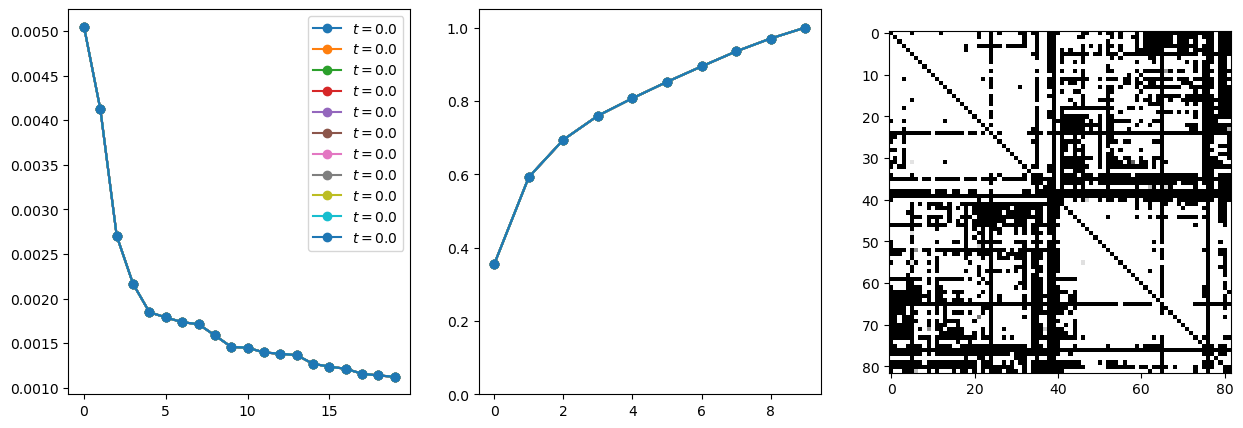

In [ ]:
from scipy.stats import binomtest

# HERE
# k[i, j] = 2*s[i, j]*f[i,j]/(f[i,j] + f[j,i])

k_threshold = 1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for k_threshold in np.arange(0, 1.1, 0.1):
    k_threshold = 0
    #k_matrix = ((2 * (bundle_prob > 0.1).astype(int) * ftract_prob)/(ftract_prob + ftract_prob.T) >= k_threshold).astype(int)
    k_matrix = (2 * bundle_prob * ftract_prob)/(ftract_prob + ftract_prob.T)
    #k_matrix = ((2 * bundle_prob * ftract_prob)/(ftract_prob + ftract_prob.T) >= k_threshold).astype(int)

    #k_matrix += k_matrix.T
    #k_matrix = (k_matrix > 0).astype(int)

    k_matrix = np.nan_to_num(k_matrix)

    zorder=1
    ls = "-o"
    if k_threshold > 0:
        zorder=0
        ls = "-"
        k_matrix = (k_matrix >= k_threshold).astype(int)

    k_matrix -= np.diag(np.diag(k_matrix))

    print(f"Directed connectome has shape: {k_matrix.shape}")
    from matplotlib.patheffects import withStroke
    from matplotlib.lines import Line2D

    vec_id = 0
    alpha_perc = 20
    add_spectrum = False
    save_fig = True

    U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(k_matrix), fix_negative=False)
    V = Vh.T

    axes[0].plot(S[:20]/(k_matrix.sum()), ls, label=f"$t={k_threshold:1.1f}$", zorder=zorder)
    axes[1].plot(np.cumsum(S[:10]**2/(S[:10]**2).sum()), ls, zorder=zorder)

axes[0].legend()

axes[1].set_ylim(0, 1.05)
axes[2].imshow(k_matrix, cmap="binary_r", vmin=0, vmax=0.9*np.max(k_matrix))

Found 12 clusters !
(82, 3)


/Users/acionca/code/dGSP/dSVD/dgsp.py:410: RuntimeWarning: invalid value encountered in divide
  receiving_communities = np.nan_to_num(
/Users/acionca/code/dGSP/dSVD/dgsp.py:415: RuntimeWarning: invalid value encountered in divide
  


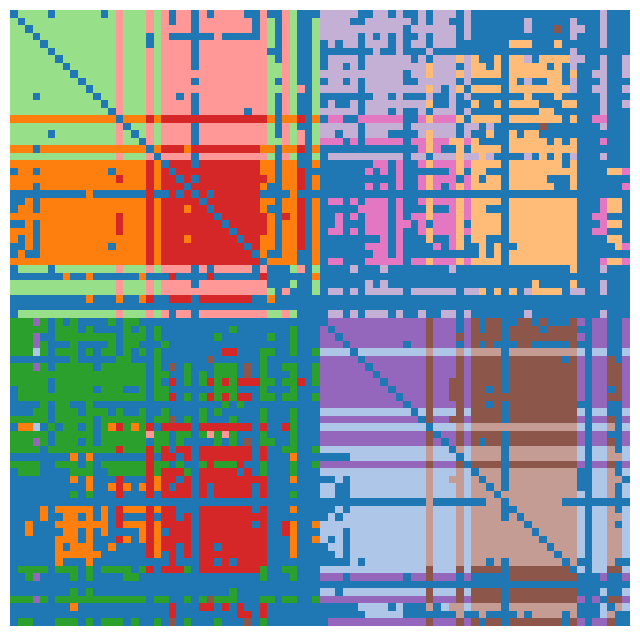

In [63]:
importlib.reload(dgsp)
importlib.reload(dgsp_plot)

from seaborn import heatmap

graph = k_matrix

U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(graph, null_model="outin"))
V = Vh.T

n_nodes = graph.shape[0]

vector_id_max = 2
n_kmeans = 12

edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, vector_id_max, method="kmeans",
                                                           n_kmeans=n_kmeans, verbose=True, max_k=20)
n_clusters = np.max(edge_clusters)

sending_communities, receiving_communities = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat, method="bimodularity")

#fig, axes = plt.subplots(ncols=2, figsize=(24, 8), gridspec_kw={"width_ratios": [1, 2]})
fig, axes = plt.subplots(figsize=(8, 8))

# Edge colors
#graph_pos = {i: (U[i, vector_id], V[i, vector_id]) for i in range(n_nodes)}
print(node_centers.shape)
graph_pos = {i: (x, y) for i, (x, y) in enumerate(zip(node_centers[:, 0], node_centers[:, 1]))}

edge_list = nx.DiGraph(graph).edges()

#axes.imshow(edge_clusters_mat, cmap="tab20", interpolation="none", vmin=0, vmax=20)
heatmap(edge_clusters_mat, cmap="tab20", ax=axes, cbar=False, vmin=0, vmax=20)

# axes.set_xticks([(2*i+1)*n_nodes//8 for i in range(4)], labels=["LH posterior", "LH anterior", "RH posterior", "RH anterior"])
# axes.set_yticks([(2*i+1)*n_nodes//8 for i in range(4)], labels=["LH posterior", "LH anterior", "RH posterior", "RH anterior"])
axes.set_xticks([])
axes.set_yticks([])

bimod = dgsp.bimod_index_nodes(graph, sending_communities, receiving_communities, scale=True)
#bimod_quad = bimod_quad**sum_power/np.sum(bimod_quad**sum_power)
sorted_id = np.flip(np.argsort(bimod))

titles = [f"$Q(C_{{{i+1}}})={bimod[i]:1.2f}$" for i in range(n_clusters)]
#titles = np.array(titles)[sorted_id]
# dgsp_plot.plot_all_bicommunity(graph, sending_communities,
#                                receiving_communities, fig=fig, axes=axes[1],
#                                scatter_only=False, titles=titles, layout=graph_pos)

titles = np.array(titles)[sorted_id]

fig.savefig(op.join(path_to_figures, f"bimodularity-MatCluster-Nvec{vector_id_max}k{n_kmeans}-{k_threshold:1.1f}-NoTicks.pdf"), bbox_inches="tight")

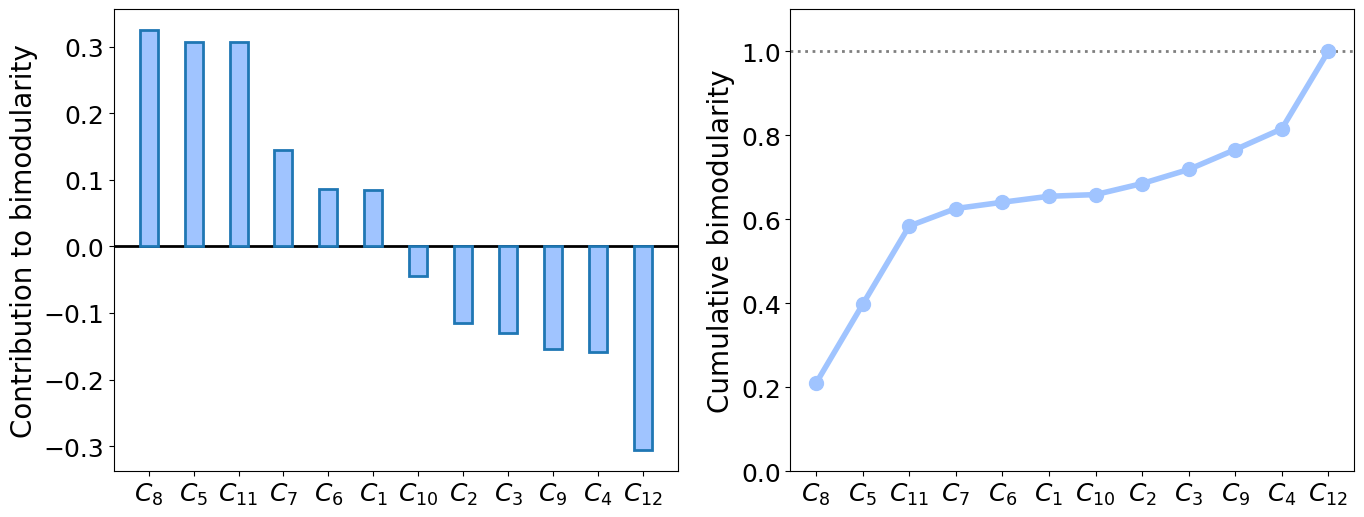

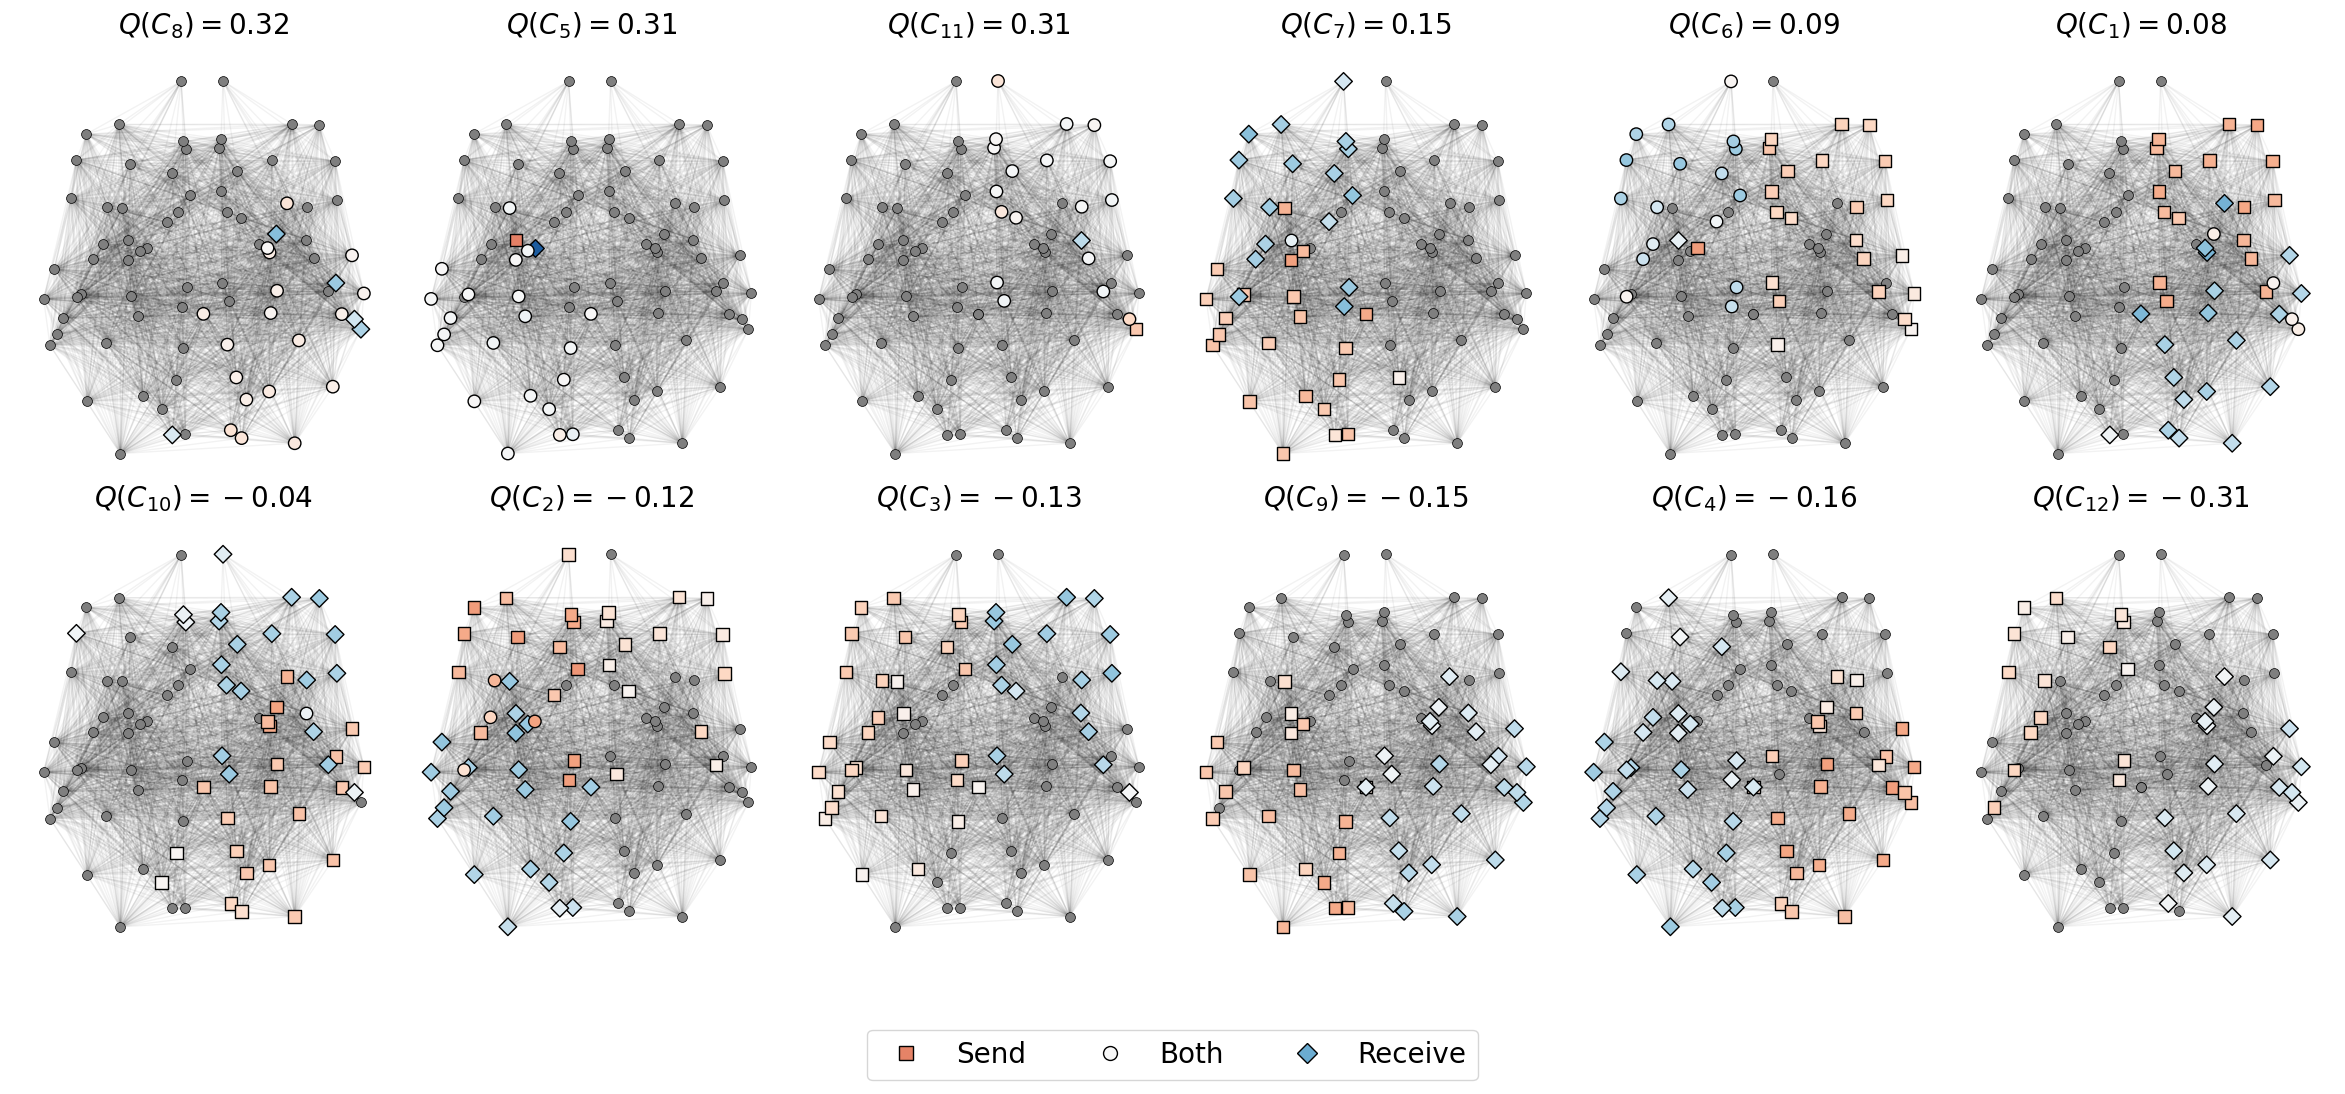

In [64]:
importlib.reload(dgsp_plot)

fig, axes = plt.subplots(figsize=(16, 6))
#dgsp_plot.plot_all_bimod_indices(graph, edge_clusters_mat, sending_communities, receiving_communities, fig=fig, axes=axes, scale_indices=True)

dgsp_plot.plot_bimod_indices(bimod, fig=fig, axes=axes, color=palette_rgb[1])

fig, axes = plt.subplots(figsize=(5*len(sending_communities)//2, 12))
dgsp_plot.plot_all_bicommunity(graph, sending_communities[sorted_id],
                               receiving_communities[sorted_id], fig=fig, axes=axes, nrows=2,
                               scatter_only=False, titles=titles, layout=graph_pos)

reorder_coms = [1, 8, 4, 7, 9, 5, 2, 0, 3, 10, 11, 6]
com_names = ["Lh post. - Lh post.", "Rh post. - Rh post.",
             "Lh ant. - Lh ant.", "Rh ant. - Rh ant.",
             "Lh post. - Lh ant.", "Rh post. - Rh ant.",
             "Lh ant. - Lh post.", "Rh ant. - Rh post.",
             "Lh ant. - Rh ant.", "Rh ant. - Lh ant.",
             "Lh post. - Rh post.", "Rh post. - Lh post.",]

In [361]:
importlib.reload(dgsp)

all_res = dgsp.benchmark_bimod(k_matrix, k_max=15, n_vec_max=5, use_nodes=True)

/Users/acionca/code/dGSP/dSVD/dgsp.py:406: RuntimeWarning: invalid value encountered in divide
  sending_communities / np.sum(edge_clusters_mat > 0, axis=1),
/Users/acionca/code/dGSP/dSVD/dgsp.py:411: RuntimeWarning: invalid value encountered in divide
  receiving_communities / np.sum(edge_clusters_mat > 0, axis=0),
/Users/acionca/code/dGSP/dSVD/dgsp.py:406: RuntimeWarning: invalid value encountered in divide
  sending_communities / np.sum(edge_clusters_mat > 0, axis=1),
/Users/acionca/code/dGSP/dSVD/dgsp.py:411: RuntimeWarning: invalid value encountered in divide
  receiving_communities / np.sum(edge_clusters_mat > 0, axis=0),
/Users/acionca/code/dGSP/dSVD/dgsp.py:406: RuntimeWarning: invalid value encountered in divide
  sending_communities / np.sum(edge_clusters_mat > 0, axis=1),
/Users/acionca/code/dGSP/dSVD/dgsp.py:411: RuntimeWarning: invalid value encountered in divide
  receiving_communities / np.sum(edge_clusters_mat > 0, axis=0),
/Users/acionca/code/dGSP/dSVD/dgsp.py:406: Run

0.4365217488903787


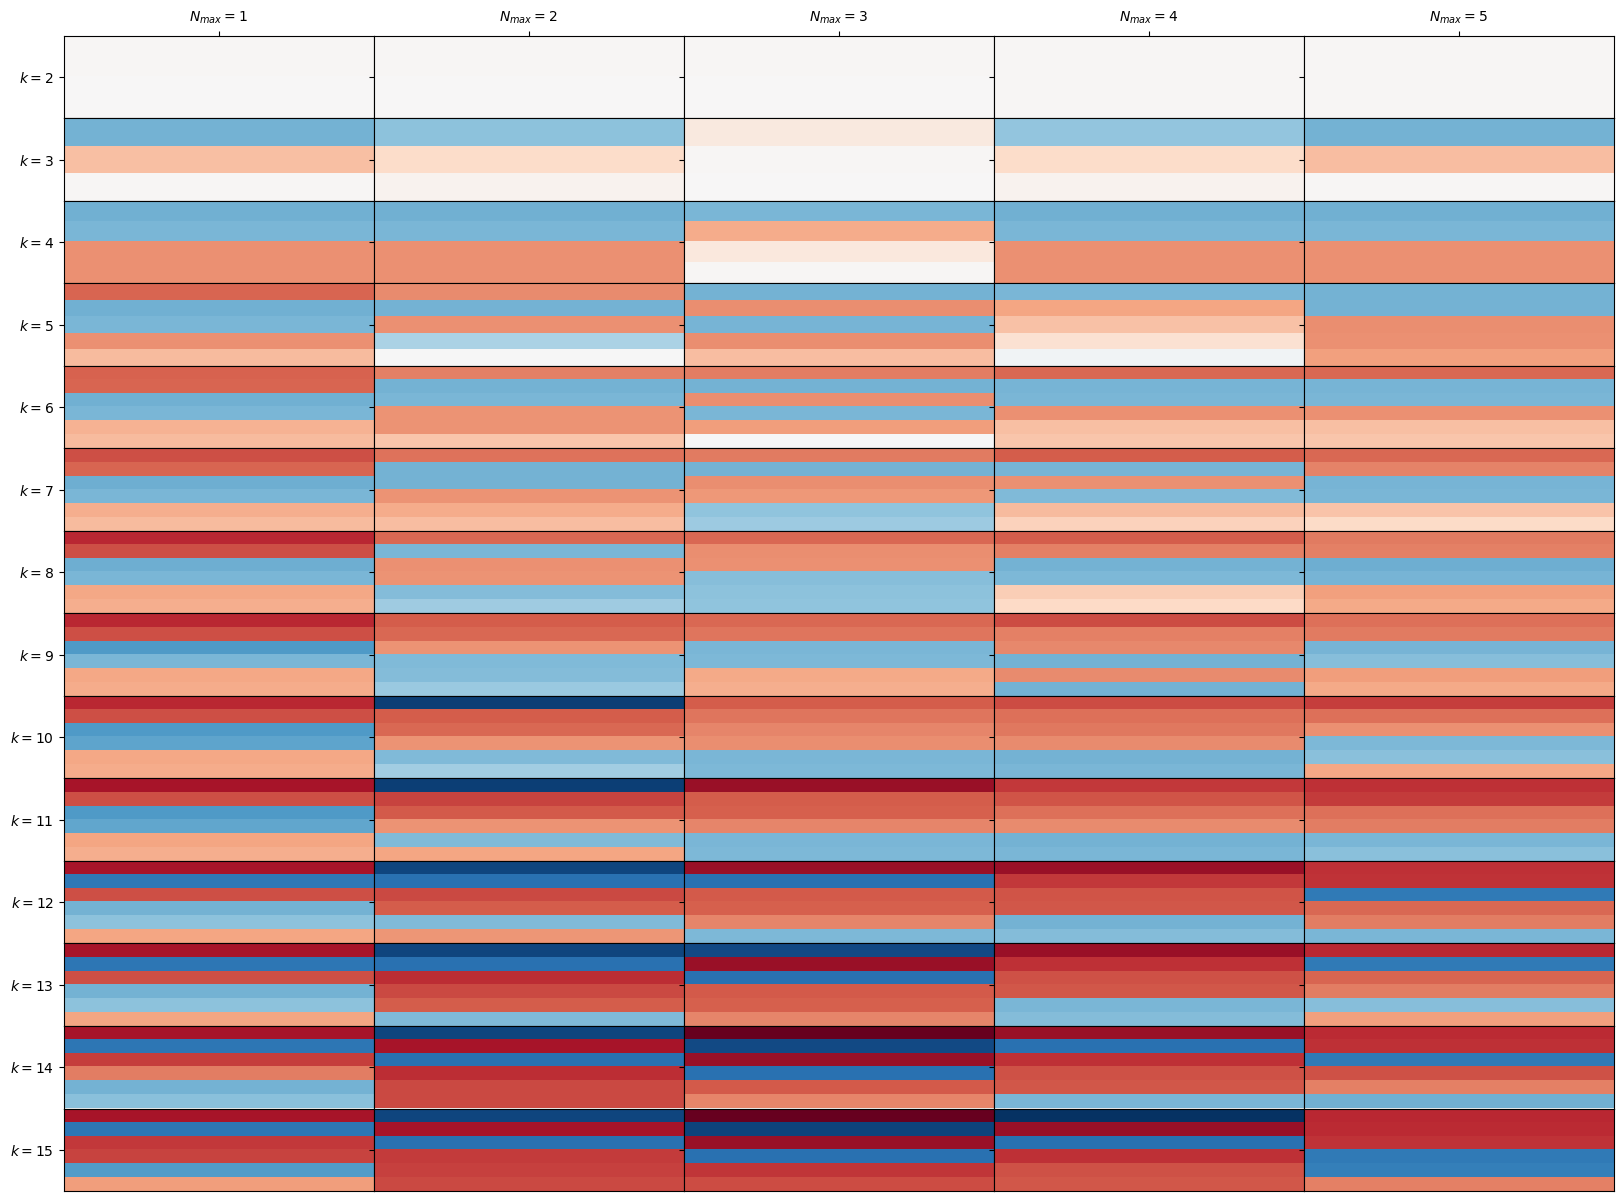

In [362]:
max_n_show = 6
maxval = max([np.max(np.abs(r_2)) for r in all_res for r_2 in r])

print(maxval)

fig, axes = plt.subplots(ncols=len(all_res), nrows=len(all_res[0]),figsize=(20, 15), gridspec_kw={"hspace": 0, "wspace": 0}, sharey="row")

for n_vec_i, res in enumerate(all_res):
    for k_i, k_res in enumerate(res):
        axes[k_i, n_vec_i].set_xticks([])
        axes[k_i, n_vec_i].set_yticks([])

        k_res_show = k_res[:np.min([len(k_res), max_n_show])]
        axes[k_i, n_vec_i].imshow(np.atleast_2d(k_res_show).T, label=f"k={k_i+1}",
                                  aspect="auto", cmap="RdBu_r", vmin=-maxval, vmax=maxval)
        
        axes[k_i, 0].set_yticks([len(k_res_show)/2-0.5], labels=[f"$k={k_i+2}$"])
    
    axes[0, n_vec_i].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    axes[0, n_vec_i].set_xticks([0], labels=[f"$N_{{max}}={n_vec_i+1}$"])

(<Figure size 1000x1000 with 5 Axes>,
 array([<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >], dtype=object))

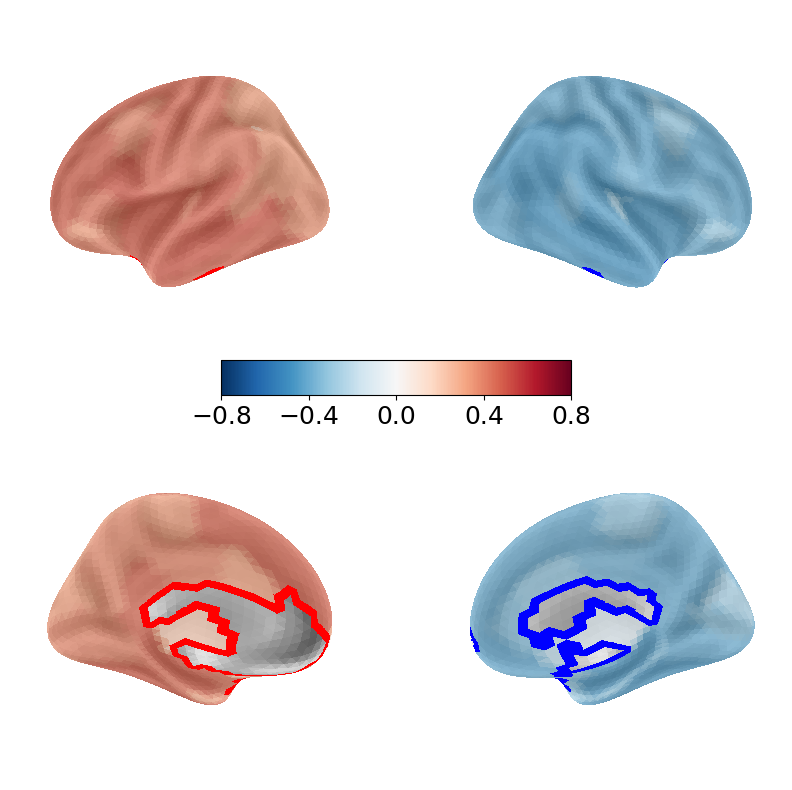

In [277]:
importlib.reload(dgsp_plot)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         subplot_kw={"projection": "3d"})
axes = axes.flatten()

dgsp_plot.plot_node_surface(surf_map, contours=[sending_surf_map, receiving_surf_map], fig=fig, axes=axes,
                            max_value=0.8, surface_name=surf_name, per_hemi=False, plot_cbar=True)

In [51]:
import nibabel as nib
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_surf_stat_map, plot_surf_contours

from skimage.filters.rank import mean
from skimage.segmentation import expand_labels

3
1
2
0


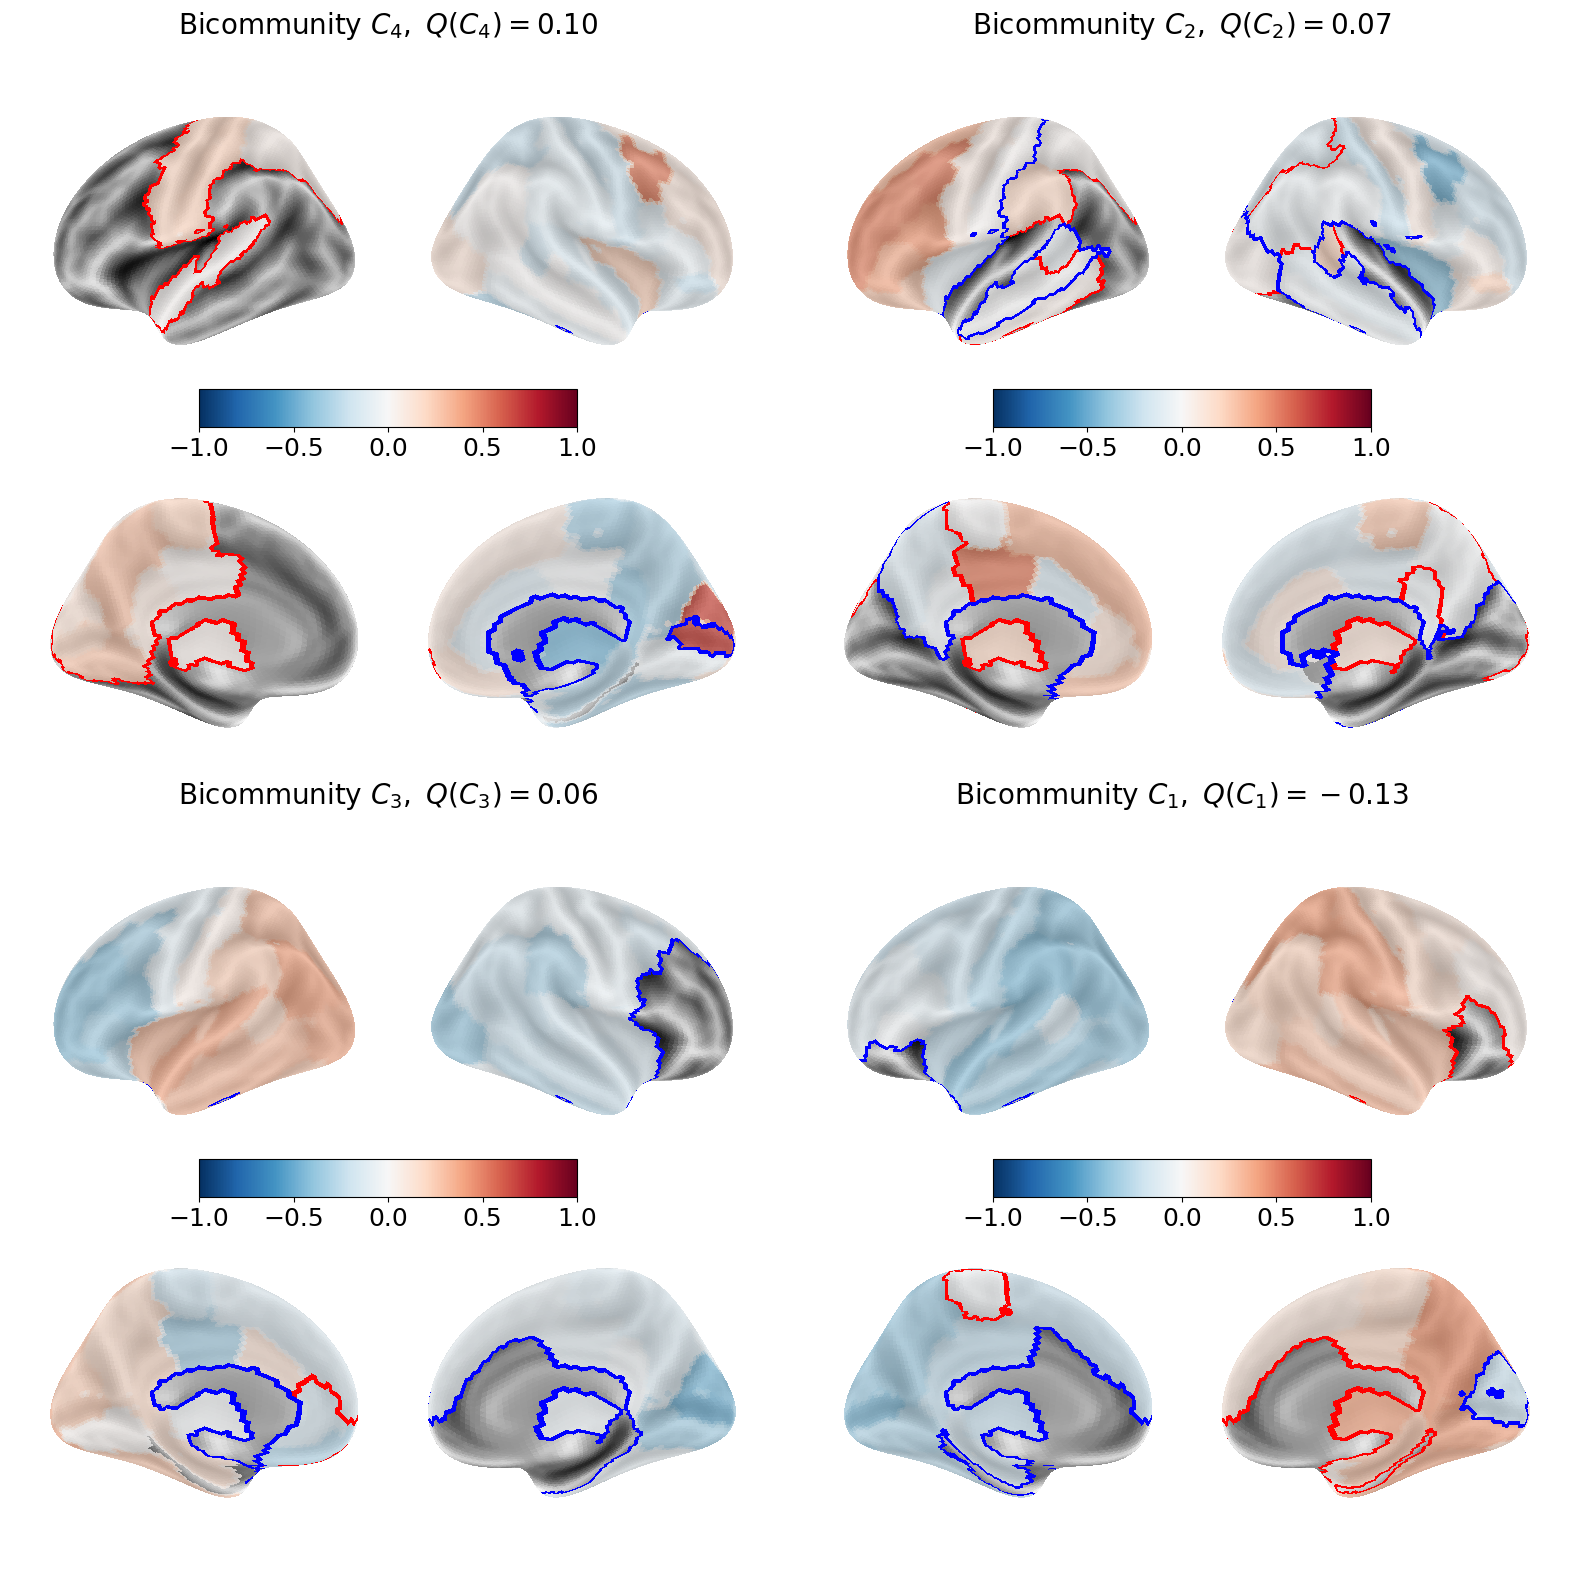

In [ ]:
importlib.reload(dgsp_plot)

path_to_ressources = "/Users/acionca/code/effectivedelay_estimation/resources"
path_to_atlas = op.join(path_to_ressources, "roi_atlas-ftract-scale1-GM.nii.gz")

titles = [f"Bicommunity $C_{{{i+1}}},$ $Q(C_{{{i+1}}})={bimod[i]:1.2f}$" for i in range(n_clusters)]
#titles = np.array(titles)[sorted_id]

#fig, all_axes = plt.subplots(nrows=n_kmeans, figsize=(20, 5*n_kmeans),
#                             gridspec_kw={"hspace": 0, "wspace": 0})

fig, all_axes = plt.subplots(nrows=n_kmeans//2+n_kmeans%2, ncols=2, figsize=(20, 5*n_kmeans),
                             gridspec_kw={"hspace": 0, "wspace": 0.05})

all_axes = all_axes.flatten()

surf_name = "fsaverage5"
maxval = 1

for ax_i, com_id in enumerate(sorted_id):
    print(com_id)
    vol_value = sending_communities[com_id] - receiving_communities[com_id]
    signals_to_surf = [vol_value, sending_communities[com_id], receiving_communities[com_id]]
    
    surf_imgs = dgsp_plot.get_node_surface(signals_to_surf, path_to_atlas=path_to_atlas, expand=2)
    surf_map, sending_surf_map, receiving_surf_map = surf_imgs

    all_axes[ax_i].axis("off")
    all_axes[ax_i].set_title(titles[com_id], fontsize=20)
    
    #gs = GridSpecFromSubplotSpec(1, 4, all_axes[ax_i], wspace=0, hspace=0)
    gs = GridSpecFromSubplotSpec(2, 2, all_axes[ax_i], wspace=0, hspace=0)
    axes = [fig.add_subplot(gs[i], projection = "3d", facecolor="none") for i in range(4)]

    dgsp_plot.plot_node_surface(surf_map, contours=[sending_surf_map, receiving_surf_map], fig=fig, axes=axes,
                                max_value=maxval, surface_name=surf_name, per_hemi=False, plot_cbar=True)

#fig.savefig(op.join(path_to_figures, f"bimod-surface_Vec{vector_id_max}K{n_kmeans}-SquareFS{surf_name[-1]}Max{maxval}.png"), dpi=300, bbox_inches="tight")

In [220]:
rois = pd.read_csv("/Users/acionca/data/F-TRACT-090624/Lausanne2008-33.txt")
rois["id"] = np.arange(rois.shape[0])+1

roi_id = 69
rois[rois.id == roi_id]

,stimulated parcels,id
68,ctx-rh-precentral,69


In [46]:
importlib.reload(dgsp_plot)

save_only = True

path_to_ressources = "/Users/acionca/code/effectivedelay_estimation/resources"
path_to_atlas = op.join(path_to_ressources, "roi_atlas-ftract-scale1-GM.nii.gz")

if n_kmeans == 12:
    titles = [f"{com_names[i]}, $Q_{{bi}}(C_{{{sort_i+1}}})={bimod[sort_i]:1.2f}$" for i, sort_i in enumerate(reorder_coms)]
    sort_vec = reorder_coms
else:
    titles = [f"Bicommunity $C_{{{i+1}}},$ $Q_{{bi}}(C_{{{i+1}}})={bimod[i]:1.2f}$" for i in range(n_clusters)]
    titles = np.array(titles)[sorted_id]
    sort_vec = sorted_id

#fig, all_axes = plt.subplots(nrows=n_kmeans, figsize=(20, 5*n_kmeans),
#                             gridspec_kw={"hspace": 0, "wspace": 0})

if save_only:
    # Turn interactive plotting off
    plt.ioff()

#fig, all_axes = plt.subplots(nrows=n_kmeans//2+n_kmeans%2, ncols=2, figsize=(20, 3*n_kmeans),
fig, all_axes = plt.subplots(nrows=n_kmeans//2+n_kmeans%2, ncols=2, figsize=(20, 2.5*n_kmeans),
                             gridspec_kw={"hspace": 0, "wspace": 0.05})

all_axes = all_axes.flatten()

surf_name = "fsaverage7"
maxval = 0.8

#maxval = [0.6] * 4 + [0.4] * 8
maxval = [0.8, 0.8, 0.6, 0.6]
#maxval = [0.6] * len(sorted_id)
#maxval = [0.6] * 4 + [0.5] * 4 + [0.4] * 4
maxname = np.unique(maxval)

if not isinstance(maxval, list):
    maxval = [maxval]*len(sorted_id)

com_colors = ["red", "blue"]

for ax_i, com_id in enumerate(sort_vec):
#for ax_i, com_id in enumerate(reorder_coms):
    print(com_id)
    signals_to_surf = [sending_communities[com_id], -receiving_communities[com_id]]
    
    surf_imgs = dgsp_plot.get_node_surface(signals_to_surf, path_to_atlas=path_to_atlas, expand=2)
    sending_surf_map, receiving_surf_map = surf_imgs

    all_axes[ax_i].axis("off")
    #all_axes[ax_i].set_title(titles[com_id], fontsize=24)
    all_axes[ax_i].set_title(titles[ax_i], fontsize=24)
    
    # all_axes[ax_i].text(0, 0.9, "Sending", fontsize=22, ha="center", va="top", rotation=90)
    # all_axes[ax_i].text(0, 0.1, "Receiving", fontsize=22, ha="center", va="bottom", rotation=90)

    all_axes[ax_i].text(0, 0.8, "Sending", fontsize=20, ha="center", va="center", rotation=90)
    all_axes[ax_i].text(0, 0.3, "Receiving", fontsize=20, ha="center", va="center", rotation=90)
    
    #gs = GridSpecFromSubplotSpec(1, 4, all_axes[ax_i], wspace=0, hspace=0)
    gs = GridSpecFromSubplotSpec(2, 4, all_axes[ax_i], wspace=0, hspace=0)

    for com_i, com in enumerate([sending_surf_map, receiving_surf_map]):
        axes = [fig.add_subplot(gs[com_i*4+i], projection = "3d", facecolor="none") for i in range(4)]

        dgsp_plot.plot_send_receive_surface(com, fig=fig, axes=axes, contour_color=com_colors[com_i],
                                            max_value=maxval[ax_i], surface_name=surf_name, per_hemi=True, plot_cbar=(com_i==0))#, cbar_h=0.5)

figname = f"bimod-surfaceSeparated_Vec{vector_id_max}K{n_kmeans}-SquareFS{surf_name[-1]}-T{k_threshold}.png"
fig.savefig(op.join(path_to_figures, figname), dpi=300, bbox_inches="tight")

if save_only:
    plt.close(fig)
    plt.ion()

1
0
3
2
